**List 6** - Algorithms and Data Structures 2021/22, WUST - F13

*Author:* Mateusz Machaj, 262288

*Date:* 10.01.2022

# Import

In [295]:
from __future__ import annotations

import re
import string
import time
from typing import Any, List, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

-----------------------

# Task 1

_**Binary search tree class implementation**_

-----------------------

Implementation is written basing on the professor's lecture notes [[1]](#ref1), but some elements are modified - especially handling duplicate keys and issues regarding PEP rules. There were also a couple of mistakes to correct.

I do not use unncessary `get` and `set` methods for attributes, because the code is written with respect to *python* conventions.

## Node class

At first I create a node class representing each unit in binary tree. 

In [2]:
class TreeNode:
    def __init__(
        self,
        key: int,
        value: Any = None,
        parent: TreeNode = None,
        left_ch: TreeNode = None,
        right_ch: TreeNode = None,
    ):
        self.key = key
        self.value = value
        self.parent = parent
        self.left_ch = left_ch
        self.right_ch = right_ch

        self.balance_fact = 0  # used only for AVL Tree

    def is_root(self) -> bool:
        return not self.parent

    def is_left_ch(self) -> bool:
        return self.parent and self.parent.left_ch is self

    def is_right_ch(self) -> bool:
        return self.parent and self.parent.right_ch is self

    def has_left_ch(self) -> bool:
        return self.left_ch

    def has_right_ch(self) -> bool:
        return self.right_ch

    def children_number(self) -> int:
        if self.left_ch and self.right_ch:
            return 2
        elif not (self.left_ch or self.right_ch):
            return 0
        else:
            return 1

    def is_leaf(self) -> bool:
        return not bool(self.children_number())

    def get_item_data(self) -> Tuple[int, Any]:
        return self.key, self.value

    def set_item_data(self, key: int, value: Any = None):
        self.key = key
        self.value = value

    def get_children(self) -> Tuple[TreeNode, TreeNode]:
        return self.left_ch, self.right_ch

    def set_children(self, left_ch: TreeNode = None, right_ch: TreeNode = None):
        if left_ch:
            self.left_ch = left_ch
            self.left_ch.parent = self
        if right_ch:
            self.right_ch = right_ch
            self.right_ch.parent = self

## Main tree class

Now, the main binary search tree class.

I assume that **repeated keys are not allowed** [[2]](#ref2). It means that left children are strictly smaller and right - strictly greater (unlike in the lecture notes).

In [3]:
class BSTree:
    def __init__(self):
        self.root = None
        self.size = 0

    def length(self) -> int:
        return self.size

    def __len__(self) -> int:
        return self.size

    def _put(self, key: int, value: Any, current_node: TreeNode):
        if key < current_node.key:
            if current_node.has_left_ch():
                self._put(key, value, current_node.left_ch)
            else:
                current_node.left_ch = TreeNode(key, value, parent=current_node)
        elif key > current_node.key:
            if current_node.has_right_ch():
                self._put(key, value, current_node.right_ch)
            else:
                current_node.right_ch = TreeNode(key, value, parent=current_node)
        elif key == current_node.key:
            current_node.value = value

    def put(self, key: int, value: Any = None):
        if self.root:
            self._put(key, value, self.root)
        else:
            self.root = TreeNode(key, value)
        self.size += 1

    def __setitem__(self, key: int, value: Any):
        self.put(key, value)

    def _get(self, key: int, current_node: TreeNode = None) -> Optional[TreeNode]:
        if not current_node:
            current_node = self.root
        if key < current_node.key:
            if current_node.has_left_ch():
                return self._get(key, current_node.left_ch)
            else:
                return None
        elif key > current_node.key:
            if current_node.has_right_ch():
                return self._get(key, current_node.right_ch)
            else:
                return None
        elif key == current_node.key:
            return current_node

    def get(self, key: int) -> Optional[Any]:
        if self.root:
            search_res = self._get(key, self.root)
            if search_res:
                return search_res.value
            else:
                return None
        else:
            return None

    def __getitem__(self, key: int) -> int:
        return self.get(key)

    def __contains__(self, key: int) -> bool:
        if self._get(key, self.root):
            return True
        else:
            return False

    def _find_min(self, current_node: TreeNode = None) -> TreeNode:
        if not current_node:
            current_node = self.root
        while current_node.has_left_ch():
            current_node = current_node.left_ch
        return current_node

    def first_item(self) -> Tuple[int, Any]:
        min_key_node = _find_min()
        return (min_key_node.key, min_key_node.value)

    def _find_max(self, current_node: TreeNode = None) -> TreeNode:
        if not current_node:
            current_node = self.root
        while current_node.has_right_ch():
            current_node = current_node.right_ch
        return current_node

    def last_item(self) -> Tuple[int, Any]:
        max_key_node = _find_max()
        return (max_key_node.key, max_key_node.value)

    def _find_successor(self, current_node: TreeNode = None) -> Optional[TreeNode]:
        if not current_node:
            current_node = self.root
        succ = None
        if current_node.has_right_ch():
            succ = self._find_min(current_node.right_ch)
        else:
            if not current_node.is_root():
                if current_node.is_left_ch():
                    succ = current_node.parent
                else:
                    current_node.parent.right_ch = None
                    succ = self._find_successor(current_node.parent)
                    current_node.parent.right_ch = current_node
        return succ

    def _remove(self, current_node: TreeNode):
        if current_node.is_leaf():
            if current_node.is_left_ch():
                current_node.parent.left_ch = None
            else:
                current_node.parent.right_ch = None
        elif current_node.children_number() == 2:
            succ = self._find_successor(current_node)
            if not succ:
                raise Exception("Successor searching error.")
            current_node.set_item_data(*succ.get_item_data())
            self._remove(succ)

        else:
            if current_node.has_left_ch():
                child = current_node.left_ch
            else:
                child = current_node.right_ch

            if current_node.is_left_ch():
                current_node.parent.set_children(child, None)
            elif current_node.is_right_ch():
                current_node.parent.set_children(None, child)
            else:
                current_node.set_item_data(*child.get_item_data())
                current_node.set_children(*child.get_children())

    def delete(self, key: int):
        if self.size > 1:
            current_node = self._get(key)
            if current_node:
                self._remove(current_node)
                self.size -= 1
            else:
                raise KeyError("Key not found.")
        elif self.size == 1 and self.root.key == key:
            self.root = None
            self.size -= 1
        else:
            raise KeyError("Key not found.")

    def __delitem__(self, key: int):
        self.delete(key)

While using the class only with the methods provided there are no issues with double keys. Changing any values manually causes many problems and creates ambiguous situation in key set. I do not handle this for obvious reasons. In other languages external inaccessibility of attributes solves it. In *python* we assume reasonable usage.

## AVG Tree

Having the basic binary search tree class, we can also implement AVL tree - as it is done in notes [[1]](#ref1), so by inheritance. This is going to be our final product.

In [4]:
class AVLTree(BSTree):
    def rotate_left(self, rot_root: TreeNode):
        pass

    def rotate_right(self, rot_root: TreeNode):
        pass

    def rebalance(self, current_node: TreeNode):
        pass

    def update_balance(self, current_node: TreeNode):
        if abs(current_node.balance_fact) > 1:
            self.rebalance(current_node)
            return
        if not current_node.is_root():
            if current_node.is_left_ch():
                current_node.parent.balance_fact += 1
            else:
                current_node.parent.balance_fact -= 1
            if current_node.parent.balance_fact != 0:
                self.update_balance(current_node.parent)

    def _put(self, key: int, value: Any, current_node: TreeNode):
        if key < current_node.key:
            if current_node.has_left_ch():
                self._put(key, value, current_node.left_ch)
            else:
                current_node.left_ch = TreeNode(key, value, parent=current_node)
                self.update_balance(current_node.left_ch)
        elif key > current_node.key:
            if current_node.has_right_ch():
                self._put(key, value, current_node.right_ch)
            else:
                current_node.right_ch = TreeNode(key, value, parent=current_node)
                self.update_balance(current_node.right_ch)
        elif key == current_node.key:
            current_node.value = value

## Presentation

In [5]:
bst1 = BSTree()
bst1[5] = 0


# bst1.delete(5)
bst1.root.key

5

In [6]:
bst = BSTree()
bst[10] = 0
bst[5] = 0
bst[7] = 0
bst[1] = 0
bst[9] = 0
bst[21] = 0
bst[2] = 0
bst[9]

# print(bst._get(5, bst.root))
bst.delete(5)
# bst._find_successor(bst._get(5)).key

-----------------------

# Task 2

_**Sorting algorithm with a binary heap**_

-----------------------

## Main class

Binary heap class will be writen also according to the professor's lecture notes [[3]](#ref3), using *python* lists in implementation - that is simply convenient.

However, in contrary to the sample shown, the *root* is identified with the **maximal** number.

In [7]:
class BinHeap:
    def __init__(self):
        self.heap_list = [0]
        self.size = 0

    def _get_parent(self, index: int) -> int:
        return index // 2

    def _get_left_ch(self, index: int) -> int:
        return index * 2

    def _get_right_ch(self, index: int) -> int:
        return index * 2 + 1

    def _perc_up(self, index: int):
        parent = self._get_parent(index)
        while parent > 0:

            if self.heap_list[index] > self.heap_list[parent]:
                self.heap_list[parent], self.heap_list[index] = (
                    self.heap_list[index],
                    self.heap_list[parent],
                )
            index = self._get_parent(index)
            parent = self._get_parent(index)

    def insert(self, value: float):
        self.heap_list.append(value)
        self.size += 1
        self._perc_up(self.size)

    def find_max(self) -> float:
        return self.heap_list[1]

    def _max_child(self, index: int) -> Optional[int]:
        left_ch = self._get_left_ch(index)
        right_ch = self._get_right_ch(index)
        if left_ch > self.size:
            return None
        elif left_ch == self.size:
            return left_ch
        else:
            if self.heap_list[left_ch] > self.heap_list[right_ch]:
                return left_ch
            else:
                return right_ch

    def _perc_down(self, index: int):
        while self._get_left_ch(index) <= self.size:
            max_ch = self._max_child(index)
            if self.heap_list[index] < self.heap_list[max_ch]:
                self.heap_list[index], self.heap_list[max_ch] = (
                    self.heap_list[max_ch],
                    self.heap_list[index],
                )
            index = max_ch

    def pop_max(self) -> float:
        return_value = self.heap_list[1]
        self.heap_list[1] = self.heap_list[self.size]
        self.heap_list.pop()
        self.size -= 1
        self._perc_down(1)
        return return_value

    def build_heap(self, alist: List[float]):
        if not all(isinstance(elem, float) or isinstance(elem, int) for elem in alist):
            raise TypeError("List should contain only numbers.")
        self.size = len(alist)
        self.heap_list = [0] + alist[:]
        index = self.size // 2
        while index > 0:
            self._perc_down(index)
            index -= 1

    def get_size(self) -> int:
        return self.size

    def __len__(self) -> int:
        return self.get_size()

    def is_empty(self) -> bool:
        return self.size == 0

    def __str__(self) -> str:
        txt = "{}".format(self.heap_list[1:])
        return txt

## Sorting

Now, using the binary heap I can write a function which **sorts the numbers in descending order**. To gain the opposite effect we should have created a *Min-Heap* instead of *Max-Heap*, but this was an aim specified on the lesson.

In [8]:
def sort_list(alist: List[float]) -> list:
    bin_heap = BinHeap()
    bin_heap.build_heap(alist)
    sorted_alist = []
    while not bin_heap.is_empty():
        sorted_alist.append(bin_heap.pop_max())
    return sorted_alist

## Complexity analysis

### Measurment tools

First step of analysis is to create a list of random numbers. I will use `np.random.random`.

Next, we have got a function measuring `sort_list` performace time. This is actually almost <u>copied</u> from my previous list [[4]](#ref4) (as well as the other following functions).

In [9]:
def time_check(size: int) -> float:
    """Chceck the performance time for `sort_list` function and given list size.

    Args:
        size (int): List length.

    Returns:
        float: Time of the operation.
    """
    alist = list(np.random.random(size))

    time_a = time.time()
    sort_list(alist)
    time_b = time.time()
    time_diff = time_b - time_a
    return time_diff

Finally a data collecting function, calling `sort_time` in loop for different sizes.

In [10]:
def collect_data(size: int, step: int) -> tuple:
    """Examine the function `sort_list` and find the calculation times for a range of sizes.

    Args:
        size (int): List length.
        step (int): Interval between sizes in tested calls.

    Returns:
        tuple: Performance data: (List lengths, Times for each size).
    """
    time_reg = []
    rng = range(1, size + 1, step)

    for N in rng:
        time_reg.append(time_check(N))

    return (rng, time_reg)

### Visualisation tools

Following function can plot graphs of the data and additionally - another "hypothetic" function.

In [11]:
def plot_data(
    x_vals: range, y_vals: list, yscale: str = "linear", function: function = None
):
    """Plot the performance data and optionally the hypothetic function that `solve` converges to in terms of time complexity.

    Args:
        x_vals (range): List sizes.
        y_vals (list): Performance times for lists.
        yscale (str, optional): Scale on Y axis. Defaults to "linear".
        function (function, optional): Hypothetic function to layer its plot with the data. Defaults to None.
    """
    plt.plot(x_vals, y_vals, "o")
    if function != None:
        f_y_vals = function(x_vals)
        plt.plot(x_vals, f_y_vals)

    plt.yscale(yscale)
    plt.xlabel("List length")
    plt.ylabel("Time")
    plt.title("Sorting function performance")
    plt.gca().legend(("Collected data", "Hypothesis"))
    plt.show()

### Data collecting

For some reasonable size and steps I collect data from function's performace.

In [12]:
size = 30000
step = 1500
data = collect_data(size, step)

### Hypothesis and its visualization

My first hypothesis would be based on the task and algorithm analysis - I assume that `sort_list` has $O(n \log(n))$ time complexity.

I use optimalization fitting tools and define new `f_fit` function as a hypothesis.

In [13]:
def func(x: float, a: float, c: float) -> float:
    """Create a cubic polynomial.

    Args:
        x (float): Independent variable.
        a (float): Multiplication factor.
        c (float): Added constant.

    Returns:
        float: Value of `n*log(n)` in some point x.
    """
    return a * x * np.log2(x) + c

In [14]:
popt, pcov = curve_fit(func, list(data[0]), data[1])
print(popt)

[8.20295440e-07 5.16610807e-03]


In [15]:
def f_fit(x: float) -> float:
    """Create a `n*log(n)` function with appropriate coefficients.

    Args:
        x (float): Independent variable.

    Returns:
        float: Function with optimal numbers set as coefficients.
    """
    return func(x, *popt)

For the fitted $A$ and $C$ values in $f(n) = A n \log(n) + C$ the comparison is presented in the graph.

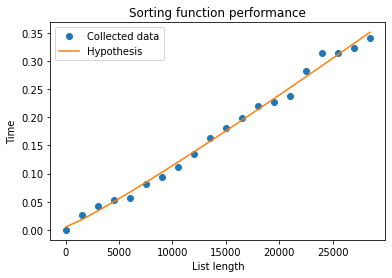

In [16]:
plot_data(*data, function=f_fit)

It seems that hypothesis was **correct**. We see a satisfying curve fit for this function.

### Prediction

Let us try predictions for sizes $n_1=30000$ and $n_2=32000$.

In [17]:
n1 = int(1e5)
n2 = int(2e5)

For $f(n_1)$:

In [18]:
f_fit(n1)

1.367647342295741

And for $f(n_2)$:

In [19]:
f_fit(n2)

2.894187664531005

### Verification

Now, we have got measured times for real `sort_list` algorithm:

In [20]:
time_check(n1)

1.5658447742462158

In [21]:
time_check(n2)

3.336216688156128

Viewing the results on my device I can claim that they actulally fit very well.

### Results

We clearly see that for greater values the assumption is good.

So, `sort_list` has **$O(n \log(n))$ time complexity** indeed.

## Presentation

In [22]:
bh = BinHeap()
bh.insert(8)
bh.insert(9)
bh.insert(2)
bh.insert(3)
bh.insert(5)
# bh.insert(6)
# bh.insert(320)
# bh.insert(1)
# bh.insert(3)
# bh.insert(18)
# bh.insert(19)


print(bh)

[9, 8, 2, 3, 5]


In [23]:
sort_list([10, 2, 50, 4, 10, 44])

[50, 44, 10, 10, 4, 2]

-----------------------

# Task 3

_**Binary heap with a limited size**_

-----------------------

This time I use *Max-Heap* again. Not to repeat the same code, I create a inheriting class and adjust necessary things.

I use a method similar to the `sort_list` function in the previous task. It is important to notice that sorted list has already a proper order for *binary heap* item list, because in our ordered list

$$a_i \geq a_j \quad\forall i < j.$$

Therefore, we have satisfied the only condition:

$$a_i \geq a_{2i}\; \land\; a_i \geq a_{2i+1} \quad\forall i.$$

That is why after each insertion or building process I check the size and in case it is to large, I sort the items and get rid of the smalest ones.

There is no need for fixing other features. We have to chceck the size only when adding something to the *heap*.

In [24]:
class LimBinHeap(BinHeap):
    def __init__(self, max_size: int):
        super().__init__()
        self.max_size = max_size

    def _sort_items(self) -> list:
        # items = self.heap_list[:]
        sorted_items = []
        while not self.is_empty():
            sorted_items.append(self.pop_max())
        self.heap_list = [0] + sorted_items
        self.size = len(sorted_items)
        # return sorted_alist

    def _is_overfilled(self) -> bool:
        return self.size > self.max_size

    def _truncate(self):
        if self._is_overfilled():
            self._sort_items()
            self.heap_list = self.heap_list[: self.max_size + 1]
            self.size = self.max_size

    def insert(self, value: float):
        super().insert(value)
        self._truncate()

    def build_heap(self, alist: List[float]):
        super().build_heap(alist)
        self._truncate()

    def is_full(self) -> bool:
        return self.size == self.max_size

## Presentation

In [25]:
bh2 = LimBinHeap(10)
bh2.build_heap([8, 7, 2, 6, 4.5, 1, 0, 5.5, 5.6, 0, 4.3, 0.5, 0.3, 0, 0, 5])
bh2.heap_list

[0, 8, 7, 6, 5.6, 5.5, 5, 4.5, 4.3, 2, 1]

-----------------------

# Task 4

_**Derivation for a given formula**_

-----------------------

## Features

I am going to implement a set of functions allowing ultimately to find the derivative of any typed function which satisfises the following conditions:

As an input there are allowed all combinations (nestings) of the functions below: 
- standard arithmetic operators: $f+g,\;f-g,\;f\cdot g,\;\frac{f}{g},\;f^g$, but also $\sqrt{f}$ - as the only explicit root;
- logarithm: $\ln(f)$; other logarithms can be gained by division;
- exponential function as $\exp(f)$;
- trigonometric functions: $\sin(f),\;\cos(f),\;\tan(f),\;\cot(f)$;
- inverse trigonometric functions: $\arcsin(f),\;\arccos(f),\;\arctan(f),\;\mathrm{arccot}(f)$.

The allowed values in functions are *numbers* (rational can be given by division) and *latin letters*.

There are the function dictionaries giving the names along with priority value. In addition to that, sets defining letters and digits (together with the *point*).

In [586]:
opers = {"+": 3, "-": 3, "*": 2, "/": 2, "^": 1}
one_arg_fncts = {
    "sqrt": 0,
    "ln": 0,
    "exp": 0,
    "sin": 0,
    "cos": 0,
    "tan": 0,
    "cot": 0,
    "arcsin": 0,
    "arccos": 0,
    "arctan": 0,
    "arccot": 0,
}
parenth = {"(": 4, ")": 4}

In [587]:
letters = set(string.ascii_lowercase).union(set(string.ascii_uppercase))
digits = set(string.digits).union({".", "-"})

## Preparation

### Formula processing

For future number syntax validation I need a proper tool: 

In [703]:
def number_validate(numbers: list):
    for numb in numbers:
        if numb.count(".") > 1:
            return False

        numb_digits = list(numb)
        if numb_digits[0] == "." or numb_digits[-1] == ".":
            return False

        if len(numb) > 1:
            if numb_digits[0] == "0" and numb_digits[1] != ".":
                return False
    return True

So, the first step after reading a string with some expression is to parse this expression.

In [704]:
def formula_parse(expression: str) -> List[str]:
    char_list = list(expression)
    comps = []
    functs = {**opers, **one_arg_fncts, **parenth}
    for name in sorted(functs, key=len, reverse=True) + list(letters):
        can_find = True
        name_len = len(name)
        while can_find:
            try:
                occur_ind = "".join(char_list).index(name)
                char_list[occur_ind : occur_ind + name_len] = [" "] * name_len
                comps.append((occur_ind, name))
            except ValueError:
                can_find = False

    if not all([_ in digits.union(" ") for _ in char_list]):
        raise ValueError("Some characters in the expression are not allowed.")

    numbers = "".join(char_list).split()

    if not number_validate(numbers):
        raise ValueError("Some numbers in the expression are not correct.")

    for numb in numbers:
        occur_ind = "".join(char_list).index(numb)
        char_list[occur_ind : occur_ind + name_len] = [" "] * name_len
        comps.append((occur_ind, numb))

    result = [None] * len(expression)
    comps_dict = dict(comps)
    for ind in sorted(comps_dict):
        result[ind] = comps_dict[ind]
    return list(filter(None, result))

Next, we can add missing multiplication symbols and on the fly investigate formulas syntax (its part regarding symbols closest neighborhood). 

In [705]:
def formula_fill(parsed_formula: List[str]):
    filled_formula = parsed_formula[:]

    def eval_type(comp):
        if comp == "-":
            return "m"
        elif comp in opers:
            return "o"
        elif comp in one_arg_fncts:
            return "1a"
        elif comp == "(":
            return "p_o"
        elif comp == ")":
            return "p_c"
        elif comp in letters:
            return "l"
        else:
            return "n"

    comp_types = [eval_type(comp) for comp in parsed_formula]
    prev_comp_type = ""
    prev_prev_comp_type = ""
    mul_to_insert = []
    min_to_insert = []
    log_to_swap = []

    for ind, comp_type in enumerate(comp_types):

        if prev_comp_type in {"p_c", "l", "n"} and comp_type in {"1a", "p_o", "l", "n"}:
            mul_to_insert.append(ind)
        if prev_comp_type in {"o", "p_o", "1a", "m"} and comp_type in {"o", "p_c"}:
            raise ValueError("Expression is inappropriate.")
        if prev_comp_type in {"o", "1a", "m"} and comp_type in {
            "m"
        }:  ########################################################################
            raise ValueError("Expression is inappropriate.")
        if (
            prev_comp_type == "m"
            and comp_type in {"1a", "p_o", "l", "n"}
            and (ind == 1 or prev_prev_comp_type == "p_o")
        ):
            min_to_insert.append(ind)
        prev_prev_comp_type = prev_comp_type
        prev_comp_type = comp_type

    for ind in sorted(mul_to_insert + min_to_insert, reverse=True):
        filled_formula.insert(ind, "*")
        if ind in min_to_insert:
            filled_formula[ind - 1] = -1

    return filled_formula

Then we can move on to changing the notation system. I will be using the *stack* class from the lecture [[5]](#ref5). 

In [706]:
class Stack:
    def __init__(self):
        self.items = []

    def is_empty(self):
        return self.items == []

    def push(self, item):
        self.items.append(item)

    def pop(self):
        return self.items.pop()

    def peek(self):
        return self.items[len(self.items) - 1]

    def size(self):
        return len(self.items)

To avoid future issues, we check parentheses correctness.

In [707]:
def parenth_checker(symbol_list: List[str]):
    stack = Stack()
    balanced = True
    ind = 0
    while ind < len(symbol_list) and balanced:
        symbol = symbol_list[ind]
        if symbol == "(":
            stack.push(symbol)
        elif symbol == ")":
            if stack.is_empty():
                balanced = False
            else:
                stack.pop()
        ind += 1

    if balanced and stack.is_empty():
        return True
    else:
        return False

At this point, a little helper function to tell whether string has a float representation. 

In [708]:
def is_float(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

Finally, transforming a prepared list into a sequence in *postfix notation*.

In [709]:
def list_to_postfix(expr_list):
    prior_dict = {**opers, **one_arg_fncts, **parenth}
    stack = Stack()
    posfix_list = []
    comp_list = expr_list

    for comp in comp_list:
        if comp in letters or is_float(comp):
            posfix_list.append(comp)
        elif comp == "(":
            stack.push(comp)
        elif comp == ")":
            top_comp = stack.pop()
            while top_comp != "(":
                posfix_list.append(top_comp)
                top_comp = stack.pop()
        else:
            while (not stack.is_empty()) and (
                prior_dict[stack.peek()] <= prior_dict[comp]
            ):
                posfix_list.append(stack.pop())
            stack.push(comp)

    while not stack.is_empty():
        posfix_list.append(stack.pop())
    return posfix_list

All this steps can be done with an aid of the function below:

In [710]:
def postfix_formula(expression: str):
    parsed = formula_parse(expression)
    filled = formula_fill(parsed)
    if parenth_checker(filled):
        return list_to_postfix(filled)
    else:
        raise Exception("Parentheses nod balances.")

### Building a tree

A simple tree can be created only using basic *node* objects with keys and referencing its children. 

In [711]:
class FormulaNode:
    def __init__(self, key, left_ch=None, right_ch=None):
        self.key = key
        self.left_ch = left_ch
        self.right_ch = right_ch

Therefore, I implement something what can easily extract a tree from a *parsed, postfix formula*.

Optional argument `replace_fncts` can be given to change some letters for real functions. It is not used in basic formula transformation, but is really handy during the recursive derivation process (later).

In [733]:
def tree_from_formula(postfix_formula: List[str], replace_fncts: dict = dict()):
    stack = Stack()
    ind = 0

    def leaf_nodif(key: Union[FormulaNode, float]):
        if not isinstance(key, FormulaNode):
            return FormulaNode(key)
        else:
            return key

    while ind < len(postfix_formula):
        comp = postfix_formula[ind]

        # optional replacing
        if comp in replace_fncts:
            comp = replace_fncts[comp]

        if comp in opers:
            right_ch = stack.pop()
            left_ch = stack.pop()
            new_node = FormulaNode(comp, left_ch, right_ch)
            stack.push(new_node)
        elif comp in one_arg_fncts:
            child = stack.pop()
            new_node = FormulaNode(comp, right_ch=child)
            stack.push(new_node)
        else:
            comp = leaf_nodif(comp)
            stack.push(comp)
        ind += 1
    root = stack.pop()
    return root

This can also help to build derivative trees only from the written formulas.

Ultimately - tree from text.

In [734]:
def get_tree(expression: str, replace_fncts=dict()):
    pf_formula = postfix_formula(expression)
    return tree_from_formula(pf_formula, replace_fncts)

## Derivation

In this step I begin with creating derivation formula tables [[6]](#ref6). They consider almost all the combinations with these functions.

It is also worth mentioning that *power* function has a quite general derivative there to handle also $f(x)^{g(x)}$. That is why

$$\frac{d}{dx}f^g = f^g (\frac{gf'}{f}+g'\ln(f)).$$

That is for $x^a$ and $a^x$ too. Fortunately, the formula above implies well known particular formulas.

In my notation, for each function $f$ and $g$, these are `f` and `g`. However, even though it might be not intuitive, $f'$ becomes `F` and the same with $g'$ - `G`.

In [766]:
deriv_formulas_oper = {
    "+": "F+G",
    "-": "F-G",
    "*": "Fg+fG",
    "/": "(Fg-fG)/g^2",
    "^": "f^g(gF/f+Glnf)",
}
deriv_formulas_oaf = {
    "sqrt": "F/(2sqrtf)",
    "ln": "F/f",
    "exp": "Fe^f",
    "sin": "Fcosf",
    "cos": "-Fsinf",
    "tan": "(1+tanf^2)F",
    "cot": "(-1-cotf^2)F",
    "arcsin": "F/sqrt(1-f^2)",
    "arccos": "-F/sqrt(1-f^2)",
    "arctan": "F/(1+f^2)",
    "arccot": "-F/(1+f^2)",
}

Main function is here below. It works recursively for branches and always decide whish formula to use, plus what is the current substitution for `f`, `g` and its derivatives. 

Moreover it uses *two-children* substitution or *one-children* version, depending on the input - whether we have got a arithmetic operator or one-argument function.

In [767]:
def derivative(formula_tree: FormulaNode, variable: str) -> list:
    def fnct_replacings(double_args: bool = True):
        if double_args:
            repl_dict = {
                "F": derivative(formula_tree.left_ch, variable),
                "G": derivative(formula_tree.right_ch, variable),
                "f": formula_tree.left_ch,
                "g": formula_tree.right_ch,
            }
        else:
            repl_dict = {
                "F": derivative(formula_tree.right_ch, variable),
                "f": formula_tree.right_ch,
            }
        return repl_dict

    comp = formula_tree.key
    if comp == variable:
        return get_tree("1")
    elif is_float(comp) or comp in letters:
        return get_tree("0")
    elif comp in deriv_formulas_oper:
        return get_tree(deriv_formulas_oper[comp], fnct_replacings())
    elif comp in deriv_formulas_oaf:
        return get_tree(deriv_formulas_oper[comp], fnct_replacings(False))
    else:
        raise Exception("Unknown derivation error.")

## Returning to the expression

Using the standard *inorder* algorithm I come back from tree to the right expression. It is "hyper-correct" version expression actually, but that is even better.

In [759]:
def formula_from_tree(root):
    expr_list = []

    def inorder(node):
        if node:
            expr_list.append("(")
            inorder(node.left_ch)
            expr_list.append(node.key)
            inorder(node.right_ch)
            expr_list.append(")")

    inorder(root)
    return "".join(map(str, expr_list))

## Presentation

In [756]:
formula_from_tree(a)

'(((0)*(f))+((-1)*(1)))'

-----------------------

<a id="ref1">[1]</a> J. Szwabiński, *Wykład 9 - Drzewa i algorytmy ich przetwarzania (ciąg dalszy)*,  *Algorytmy i struktury danych*, p. 2-16. [accessed: 08.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/9.pdf.

<a id="ref2">[2]</a> M. Hofri; H. Mahmoud, *Algorithmics of Nonuniformity: Tools and Paradigms*, 2019, p. 261.

<a id="ref3">[3]</a> J. Szwabiński, *Wykład 8 - Drzewa i algorytmy ich przetwarzania*,  *Algorytmy i struktury danych*, p. 17-24. [accessed: 08.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/9.pdf.

<a id="ref4">[4]</a> File *"lista5_machaj.ipynb"* was sent as a task via email. It <u>might</u> be also posted on my *GitHub*. Link: https://github.com/o-mateo-o.

<a id="ref5">[5]</a> J. Szwabiński, *Wykłady 2 i 3 - Abstrakcyjne struktury danych*,  *Algorytmy i struktury danych*, p. 6-17. [accessed: 08.01.2022]. Link: http://prac.im.pwr.wroc.pl/~szwabin/assets/algo/lectures/2.pdf.


<a id="ref6">[6]</a> *Tablica pochodnych funkcji elementarnych*; *Wzory o pochodnej funkcji*, GiS Wrocław, [accessed: 08.01.2022]. Link: http://www.gis.wroc.pl/pdf/pochodne.pdf.